In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests

In [67]:
%matplotlib inline

In [68]:
url = 'https://pomber.github.io/covid19/timeseries.json'
filedata = requests.get(url)
data = json.loads(filedata.content)

In [69]:
country = 'Philippines' # e.g., 'US', 'Italy', 'Philippines'

df = pd.DataFrame()
df['date'] = [m['date'] for m in data[country]]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df[country] = [m['confirmed'] for m in data[country]]
df[country + '/dt'] = np.gradient(df.get(country,'confirmed'))
df[country + '/dt2'] = np.gradient(df.get(country + '/dt','confirmed'))
df[country + '-rem'] = [m['recovered'] for m in data[country]]
df[country + '-abs'] = df[country] - df[country + '-rem']

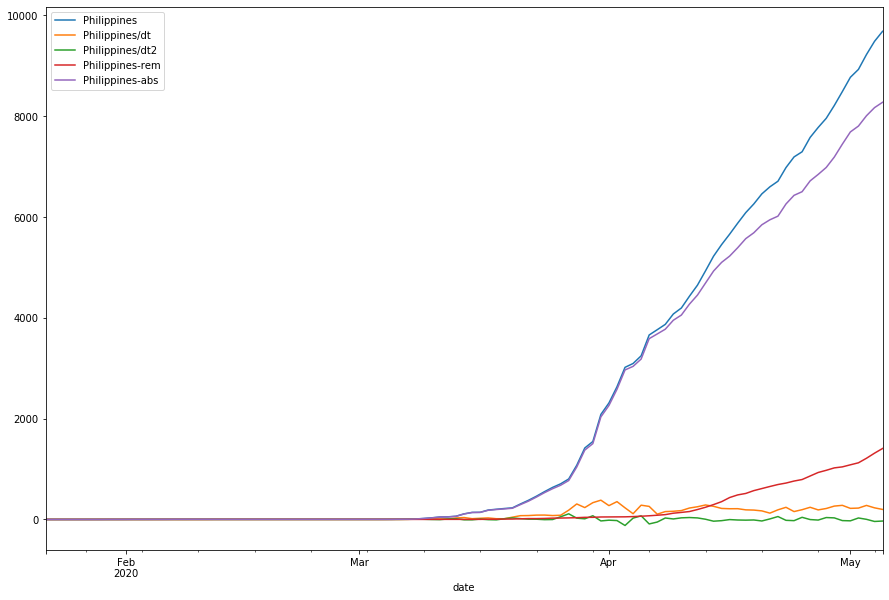

In [70]:
df.plot(figsize=(15,10))

In [71]:
print("Total cases [{0}]:           {1}".format(country, df[country][-1]))
print("New cases rate [{0}]:        {1}".format(country, df[country + '/dt'][-1]))
print("New cases rate change [{0}]: {1}".format(country, df[country + '/dt2'][-1]))
print("Recovered cases [{0}]:       {1}".format(country, df[country + '-rem'][-1]))
print("Active cases [{0}]:          {1}".format(country, df[country + '-abs'][-1]))

Total cases [Philippines]:           9684
New cases rate [Philippines]:        199.0
New cases rate change [Philippines]: -31.5
Recovered cases [Philippines]:       1408
Active cases [Philippines]:          8276


In [72]:
intensive_care_capacity = 30000
intensive_care_factor = 1/100
infection_duration_days = 21

N_de = 1387297452 # 331002651 # 83019213
I_de = df['{0}-abs'.format(country)][-1]
R_de = df['{0}-rem'.format(country)][-1]

beta_de = df['{0}/dt'.format(country)][-1] / df['{0}-abs'.format(country)][-1]

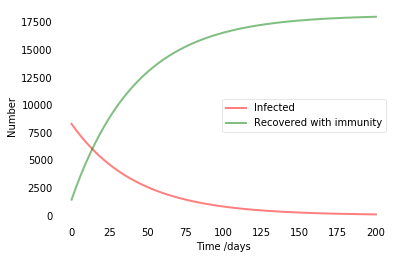

In [73]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = N_de
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = I_de, R_de
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = beta_de, 1./infection_duration_days
# A grid of time points (in days)
t = np.linspace(0, 200, 200)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
# ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

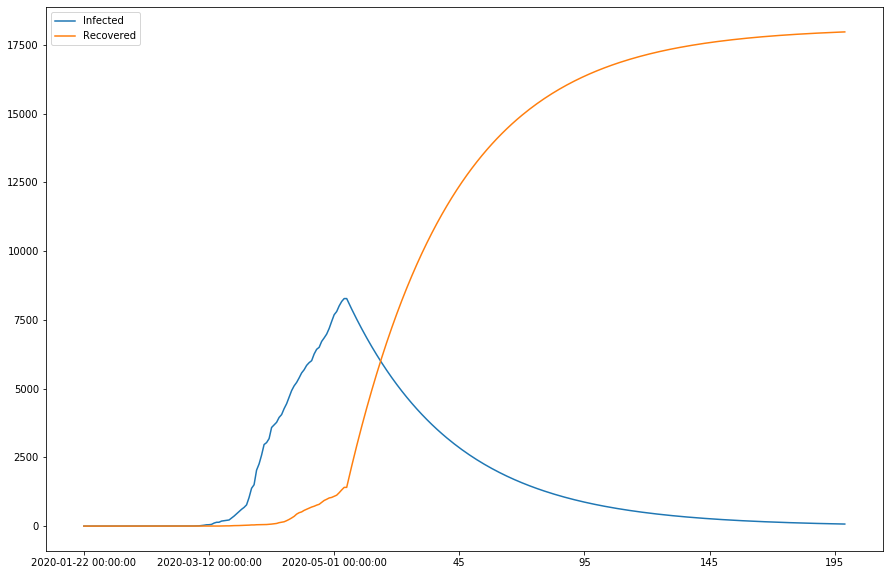

In [74]:
df_pred = pd.DataFrame([df['{0}-abs'.format(country)].append(pd.Series(I)), 
                        df['{0}-rem'.format(country)].append(pd.Series(R))])

transposed = df_pred.T

transposed.columns=['Infected', 'Recovered']

transposed.reset_index()

transposed.plot(figsize=(15,10))